In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

# Configura o estilo dos gráficos para um visual mais agradável
sns.set_theme(style="whitegrid")

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [2]:
print("--- Carregando TODOS os Dados Brutos ---")

# Define o caminho para a pasta onde os dados brutos estão salvos
caminho_dados_brutos = os.path.join('..', '01_dados_brutos')

# Usa o glob para encontrar todos os arquivos .csv dentro da pasta
todos_os_arquivos = glob.glob(os.path.join(caminho_dados_brutos, "*.csv"))

if not todos_os_arquivos:
    print(f"ERRO: Nenhum arquivo .csv encontrado na pasta '{caminho_dados_brutos}'")
else:
    print(f"Encontrados {len(todos_os_arquivos)} arquivos CSV para carregar.")
    
    # Cria uma lista vazia para armazenar os dados de cada arquivo
    lista_de_dataframes = []

    # Loop para ler cada arquivo CSV
    for arquivo in todos_os_arquivos:
        print(f"Lendo o arquivo: {os.path.basename(arquivo)}")
        # Lê o CSV usando a codificação 'latin1'
        df_temp = pd.read_csv(arquivo, encoding='latin1')
        lista_de_dataframes.append(df_temp)

    # Concatena todos os DataFrames da lista em um único DataFrame
    df_long = pd.concat(lista_de_dataframes, ignore_index=True)

    print("\n--- DADOS COMPLETOS CARREGADOS ---")
    print("Amostra dos dados:")
    display(df_long.head())

    print("\nInformações gerais sobre o DataFrame completo:")
    df_long.info()

--- Carregando TODOS os Dados Brutos ---
Encontrados 16 arquivos CSV para carregar.
Lendo o arquivo: SP201501.csv
Lendo o arquivo: SP201502.csv
Lendo o arquivo: SP201601.csv
Lendo o arquivo: SP201602.csv
Lendo o arquivo: SP201701.csv
Lendo o arquivo: SP201702.csv
Lendo o arquivo: SP201801.csv
Lendo o arquivo: SP201802.csv
Lendo o arquivo: SP201901.csv
Lendo o arquivo: SP201902.csv
Lendo o arquivo: SP202001.csv
Lendo o arquivo: SP202002.csv
Lendo o arquivo: SP202101.csv
Lendo o arquivo: SP202102.csv
Lendo o arquivo: SP202201.csv
Lendo o arquivo: SP202202.csv

--- DADOS COMPLETOS CARREGADOS ---
Amostra dos dados:


,Data,Hora,Estacao,Codigo,Poluente,Valor,Unidade,Tipo
0,2015-01-01,01:00,Americana - Vila Santa Maria,SP01,MP10,65.0,ug/m3,automatica
1,2015-01-01,02:00,Americana - Vila Santa Maria,SP01,MP10,98.0,ug/m3,automatica
2,2015-01-01,03:00,Americana - Vila Santa Maria,SP01,MP10,79.0,ug/m3,automatica
3,2015-01-01,04:00,Americana - Vila Santa Maria,SP01,MP10,53.0,ug/m3,automatica
4,2015-01-01,05:00,Americana - Vila Santa Maria,SP01,MP10,35.0,ug/m3,automatica



Informações gerais sobre o DataFrame completo:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12663857 entries, 0 to 12663856
Data columns (total 8 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Data      object 
 1   Hora      object 
 2   Estacao   object 
 3   Codigo    object 
 4   Poluente  object 
 5   Valor     float64
 6   Unidade   object 
 7   Tipo      object 
dtypes: float64(1), object(7)
memory usage: 772.9+ MB


In [3]:
print("Iniciando limpeza e transformação dos dados...")

# 1. Converte Data e Hora para datetime
df_long['datetime'] = pd.to_datetime(df_long['Data'] + ' ' + df_long['Hora'], errors='coerce')
df_long.dropna(subset=['datetime'], inplace=True)

# 2. Filtra para a estação de 'Ibirapuera', que sabemos que existe no arquivo.
nome_da_estacao_correto = 'Ibirapuera' 
df_filtrado = df_long[df_long['Estacao'] == nome_da_estacao_correto].copy()

print(f"\nEncontrados {len(df_filtrado)} registros para a estação '{nome_da_estacao_correto}'.")

# 3. Faz a pivotagem para o formato "wide"
df_wide = df_filtrado.pivot_table(index='datetime', columns='Poluente', values='Valor')

# 4. Lida com valores ausentes
df_wide = df_wide.interpolate(method='linear', limit_direction='forward', axis=0).fillna(0)

print("\n--- DADOS TRANSFORMADOS ---")
print(f"Dados da estação de {nome_da_estacao_correto}:")
display(df_wide.head())

print("\n--- COLUNAS DE POLUENTES DISPONÍVEIS ---")
print(df_wide.columns.tolist())
df_wide.to_csv(os.path.join('..', '02_dados_processados', 'dados_limpos_wide.csv'))

Iniciando limpeza e transformação dos dados...

Encontrados 225523 registros para a estação 'Ibirapuera'.

--- DADOS TRANSFORMADOS ---
Dados da estação de Ibirapuera:


Poluente,CO,FMC,MP2.5,NO,NO2,O3,PTS
datetime,,,,,,,
2015-01-01 01:00:00,499.064588,0.0,0.0,0.0,0.0,52.0,0.0
2015-01-01 02:00:00,623.830735,0.0,0.0,0.0,15.0,48.0,0.0
2015-01-01 03:00:00,623.830735,0.0,0.0,0.0,17.0,40.0,0.0
2015-01-01 04:00:00,623.830735,0.0,0.0,0.0,18.0,42.0,0.0
2015-01-01 05:00:00,623.830735,0.0,2.0,0.0,19.0,34.0,0.0



--- COLUNAS DE POLUENTES DISPONÍVEIS ---
['CO', 'FMC', 'MP2.5', 'NO', 'NO2', 'O3', 'PTS']


Gerando gráfico de série temporal para MP2.5...


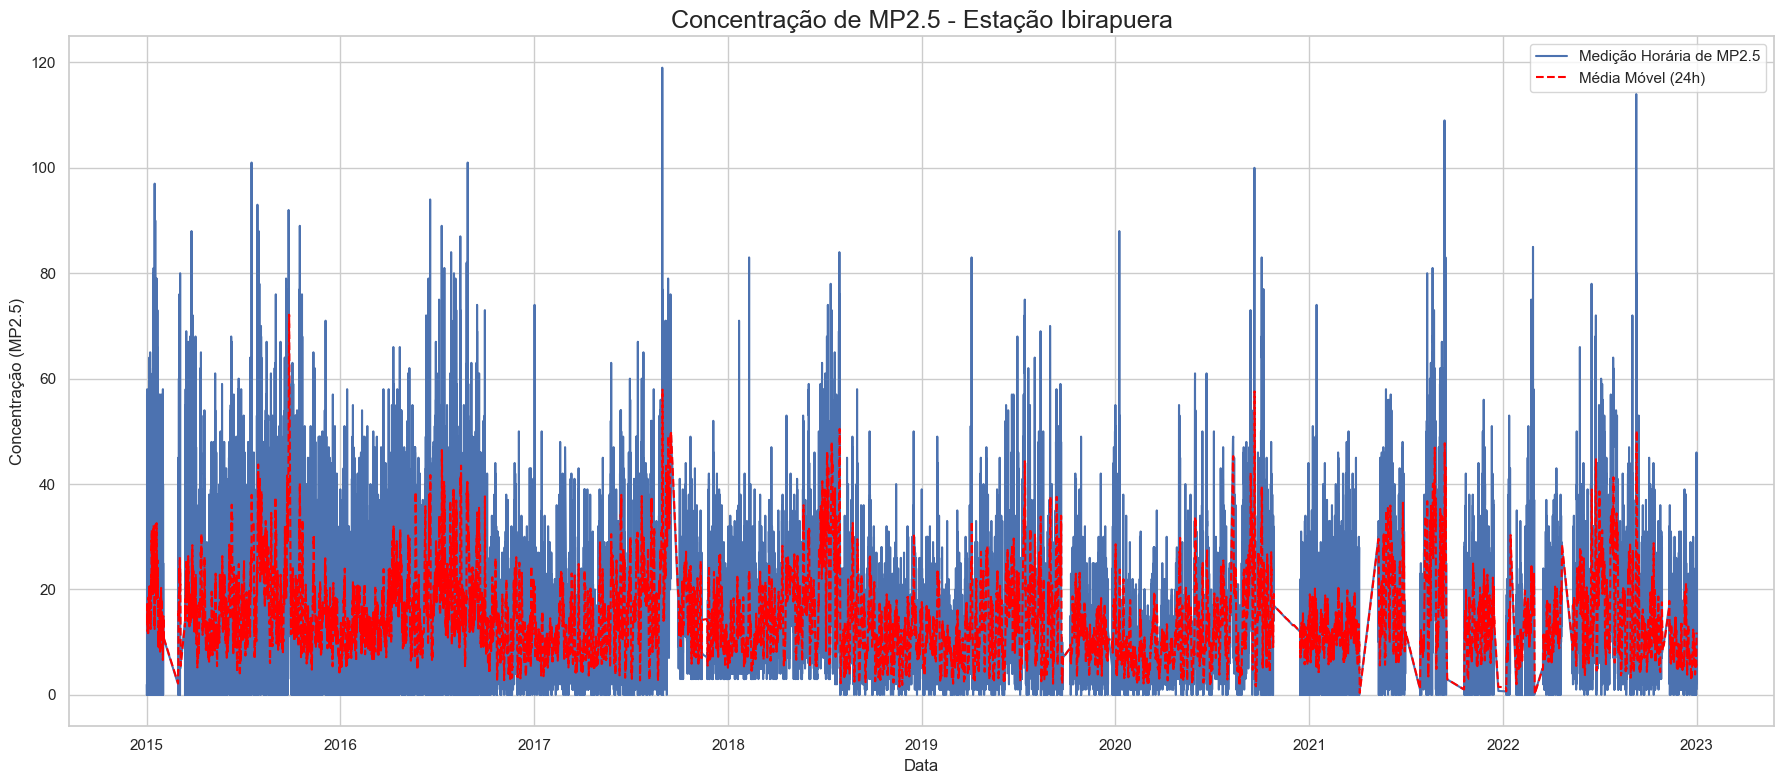

In [4]:
# Define o poluente que queremos analisar (use um nome da lista de colunas acima)
poluente_alvo = 'MP2.5'

# Verifica se o DataFrame não está vazio e se a coluna do poluente existe
if df_wide.empty or poluente_alvo not in df_wide.columns:
    print(f"ERRO: Não há dados para o poluente '{poluente_alvo}' na estação '{nome_da_estacao_correto}'.")
    print(f"Poluentes disponíveis: {df_wide.columns.tolist()}")
else:
    print(f"Gerando gráfico de série temporal para {poluente_alvo}...")

    plt.figure(figsize=(18, 8))

    # Usa a variável 'df_wide' correta
    plt.plot(df_wide.index, df_wide[poluente_alvo], label=f'Medição Horária de {poluente_alvo}')

    media_movel_24h = df_wide[poluente_alvo].rolling(window=24).mean()
    plt.plot(media_movel_24h.index, media_movel_24h, label='Média Móvel (24h)', color='red', linestyle='--')

    # Configurações do gráfico
    plt.title(f'Concentração de {poluente_alvo} - Estação {nome_da_estacao_correto}', fontsize=18)
    plt.xlabel('Data', fontsize=12)
    plt.ylabel(f'Concentração ({poluente_alvo})', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.show()

Calculando médias diárias e mensais...


C:\Users\pedrofeltrim\AppData\Local\Temp\ipykernel_8932\451273294.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_mensal = df_wide.resample('M').mean()


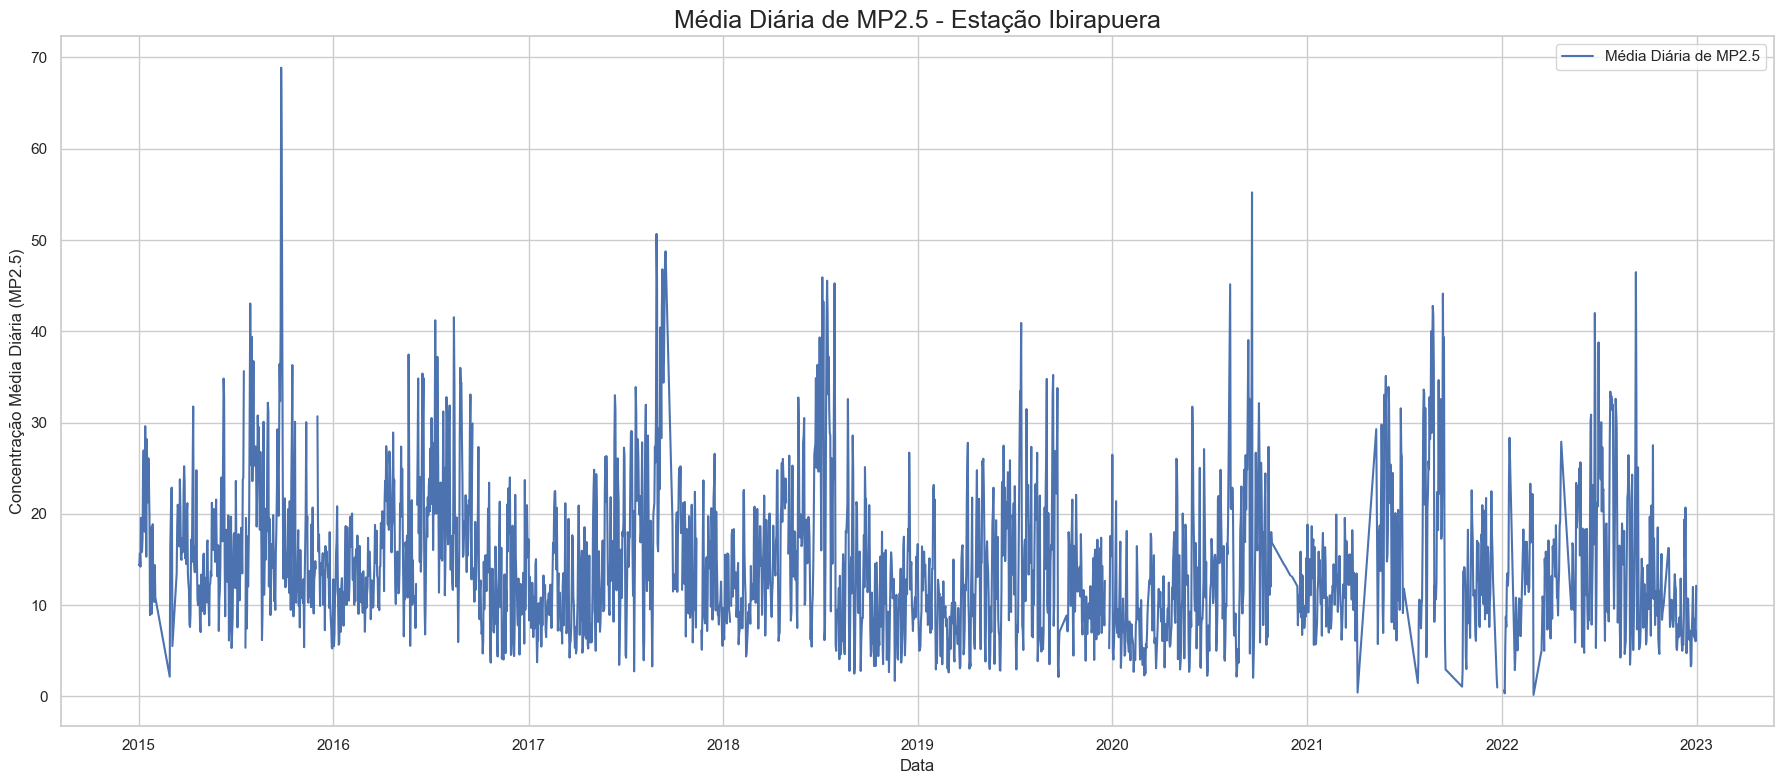

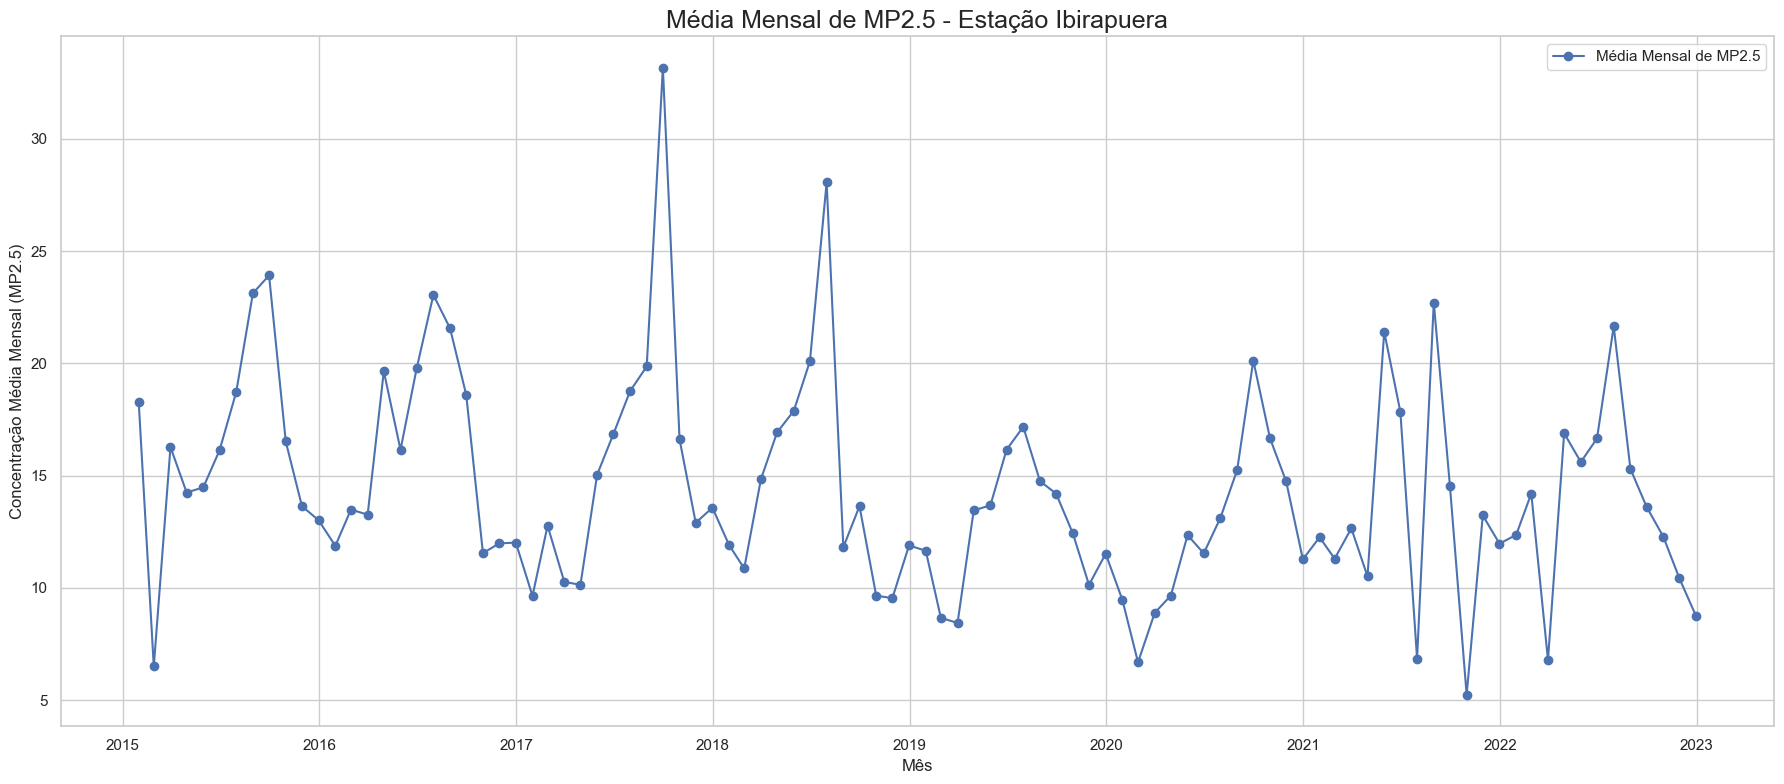

In [5]:
# Garante que o DataFrame 'df_wide' exista. Se não, rode as células anteriores.
if 'df_wide' not in locals():
    print("ERRO: DataFrame 'df_wide' não encontrado. Por favor, execute as células 2 e 3 primeiro.")
else:
    print("Calculando médias diárias e mensais...")
    # 'D' para dia (Day), 'M' para mês (Month)
    df_diario = df_wide.resample('D').mean()
    df_mensal = df_wide.resample('M').mean()

    # --- Gráfico de Média Diária ---
    plt.figure(figsize=(18, 8))
    plt.plot(df_diario.index, df_diario[poluente_alvo], label=f'Média Diária de {poluente_alvo}')
    plt.title(f'Média Diária de {poluente_alvo} - Estação {nome_da_estacao_correto}', fontsize=18)
    plt.xlabel('Data', fontsize=12)
    plt.ylabel(f'Concentração Média Diária ({poluente_alvo})', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Gráfico de Média Mensal ---
    plt.figure(figsize=(18, 8))
    plt.plot(df_mensal.index, df_mensal[poluente_alvo], label=f'Média Mensal de {poluente_alvo}', marker='o')
    plt.title(f'Média Mensal de {poluente_alvo} - Estação {nome_da_estacao_correto}', fontsize=18)
    plt.xlabel('Mês', fontsize=12)
    plt.ylabel(f'Concentração Média Mensal ({poluente_alvo})', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Calculando a matriz de correlação entre os poluentes...


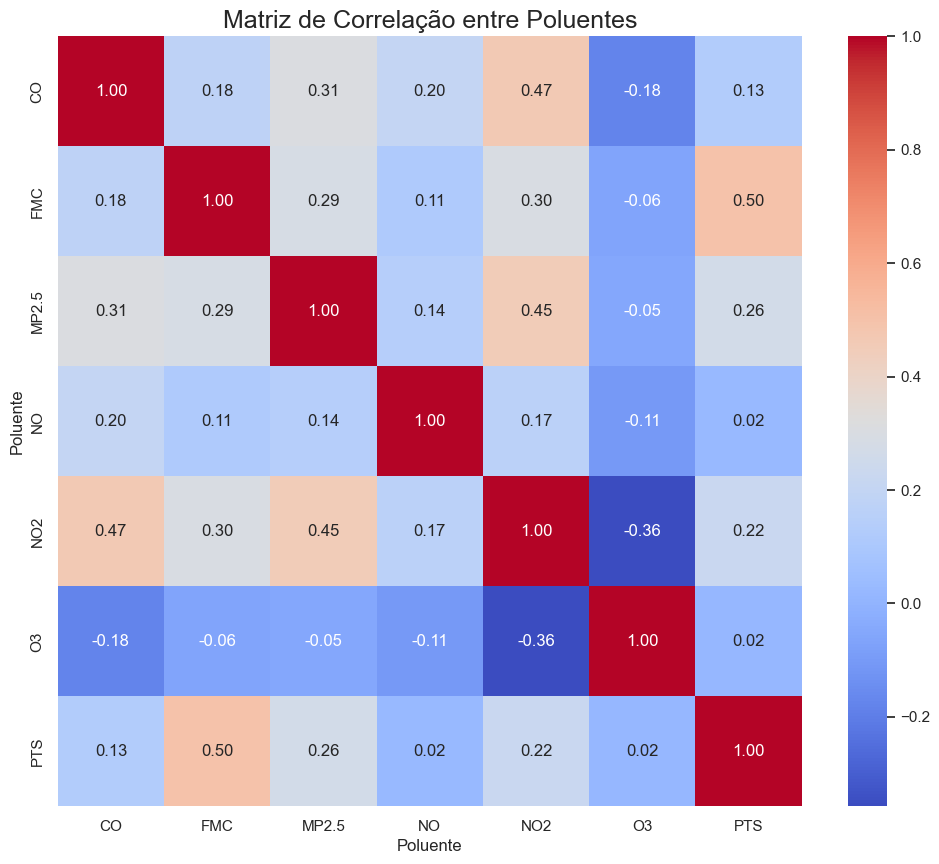


Como ler o gráfico: Valores próximos de 1.0 (vermelho escuro) indicam uma forte correlação positiva (quando um sobe, o outro sobe). Valores próximos de -1.0 (azul escuro) indicam uma forte correlação negativa (quando um sobe, o outro desce). Valores próximos de 0 indicam pouca ou nenhuma correlação.


In [6]:
print("Calculando a matriz de correlação entre os poluentes...")

# Calcula a correlação
corr_matrix = df_wide.corr()

# Cria um mapa de calor (heatmap) para visualizar a correlação
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação entre Poluentes', fontsize=18)
plt.show()

print("\nComo ler o gráfico: Valores próximos de 1.0 (vermelho escuro) indicam uma forte correlação positiva (quando um sobe, o outro sobe). Valores próximos de -1.0 (azul escuro) indicam uma forte correlação negativa (quando um sobe, o outro desce). Valores próximos de 0 indicam pouca ou nenhuma correlação.")

Analisando a distribuição de poluição por dia da semana...


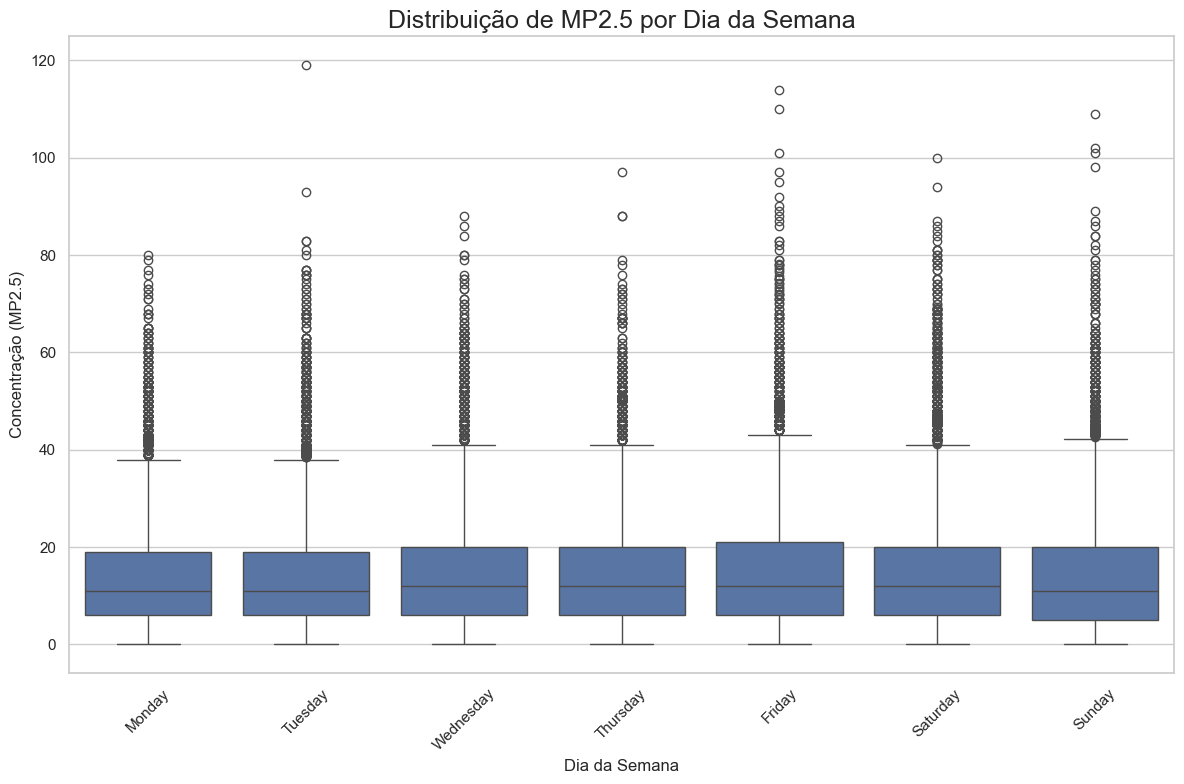


Como ler o gráfico: Cada 'caixa' representa a variação dos dados para aquele dia. A linha no meio da caixa é a mediana (o valor central). 'Bigodes' mais longos e pontos fora da caixa indicam maior variabilidade e picos de poluição.


In [7]:
print("Analisando a distribuição de poluição por dia da semana...")

# Cria uma nova coluna com o nome do dia da semana
df_wide['dia_da_semana'] = df_wide.index.day_name()

# Define a ordem correta dos dias da semana para o gráfico
ordem_dias = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Cria o boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_wide, x='dia_da_semana', y=poluente_alvo, order=ordem_dias)
plt.title(f'Distribuição de {poluente_alvo} por Dia da Semana', fontsize=18)
plt.xlabel('Dia da Semana', fontsize=12)
plt.ylabel(f'Concentração ({poluente_alvo})', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nComo ler o gráfico: Cada 'caixa' representa a variação dos dados para aquele dia. A linha no meio da caixa é a mediana (o valor central). 'Bigodes' mais longos e pontos fora da caixa indicam maior variabilidade e picos de poluição.")

In [8]:
print("Iniciando a Engenharia de Features...")

# Garante que o DataFrame 'df_wide' exista.
if 'df_wide' not in locals() or df_wide.empty:
    print("ERRO: DataFrame 'df_wide' não encontrado ou vazio. Execute as células anteriores primeiro.")
else:
    # Cria uma cópia para não alterar o DataFrame original
    df_modelo = df_wide.copy()

    # --- 1. Features baseadas no tempo ---
    # O modelo pode aprender padrões com base na hora, dia da semana, mês, etc.
    df_modelo['hora'] = df_modelo.index.hour
    df_modelo['dia_da_semana'] = df_modelo.index.dayofweek # Segunda=0, Domingo=6
    df_modelo['mes'] = df_modelo.index.month
    df_modelo['dia_do_ano'] = df_modelo.index.dayofyear

    # --- 2. Features de Lag (valores passados) ---
    # Informar ao modelo qual era o valor do poluente X horas atrás é uma "pista" muito forte.
    # Vamos criar "lags" para as 3 horas anteriores.
    poluente_alvo = 'MP2.5'
    for i in range(1, 4):
        df_modelo[f'lag_{i}h'] = df_modelo[poluente_alvo].shift(i)

    # --- 3. Feature de Média Móvel ---
    # A média das últimas horas também é uma ótima "pista".
    df_modelo['media_movel_3h'] = df_modelo[poluente_alvo].shift(1).rolling(window=3).mean()

    # Como as features de lag e média móvel criam valores nulos no início, vamos removê-los
    df_modelo = df_modelo.dropna()
    
    print("\n--- FEATURES CRIADAS COM SUCESSO ---")
    print("Novas colunas adicionadas ao DataFrame:")
    display(df_modelo.head())
    
    print("\nDimensões do DataFrame final para o modelo:", df_modelo.shape)

Iniciando a Engenharia de Features...

--- FEATURES CRIADAS COM SUCESSO ---
Novas colunas adicionadas ao DataFrame:


Poluente,CO,FMC,MP2.5,NO,NO2,O3,PTS,dia_da_semana,hora,mes,dia_do_ano,lag_1h,lag_2h,lag_3h,media_movel_3h
datetime,,,,,,,,,,,,,,,
2015-01-01 04:00:00,623.830735,0.0,0.0,0.0,18.0,42.0,0.0,3,4,1,1,0.0,0.0,0.0,0.000000
2015-01-01 05:00:00,623.830735,0.0,2.0,0.0,19.0,34.0,0.0,3,5,1,1,0.0,0.0,0.0,0.000000
2015-01-01 06:00:00,623.830735,0.0,29.0,0.0,21.0,26.0,0.0,3,6,1,1,2.0,0.0,0.0,0.666667
2015-01-01 07:00:00,623.830735,0.0,29.0,0.0,27.0,18.0,0.0,3,7,1,1,29.0,2.0,0.0,10.333333
2015-01-01 08:00:00,623.830735,0.0,35.0,0.0,24.0,20.0,0.0,3,8,1,1,29.0,29.0,2.0,20.000000



Dimensões do DataFrame final para o modelo: (66219, 15)


In [9]:
print("Separando os dados em conjuntos de treino e teste...")

# Define a variável que queremos prever (o alvo)
alvo = 'MP2.5'

# Todas as outras colunas serão as "pistas" (features)
features = [col for col in df_modelo.columns if col != alvo]

# Separa as features (X) e o alvo (y)
X = df_modelo[features]
y = df_modelo[alvo]

# Vamos usar 80% dos dados para treino e os 20% finais para teste
tamanho_treino = int(len(df_modelo) * 0.8)

X_treino, X_teste = X.iloc[:tamanho_treino], X.iloc[tamanho_treino:]
y_treino, y_teste = y.iloc[:tamanho_treino], y.iloc[tamanho_treino:]

print("\n--- DADOS SEPARADOS ---")
print(f"Tamanho do conjunto de treino: {len(X_treino)} registros")
print(f"Tamanho do conjunto de teste:  {len(X_teste)} registros")
print(f"\nPeríodo de treino: de {X_treino.index.min()} até {X_treino.index.max()}")
print(f"Período de teste:  de {X_teste.index.min()} até {X_teste.index.max()}")

Separando os dados em conjuntos de treino e teste...

--- DADOS SEPARADOS ---
Tamanho do conjunto de treino: 52975 registros
Tamanho do conjunto de teste:  13244 registros

Período de treino: de 2015-01-01 04:00:00 até 2021-05-15 10:00:00
Período de teste:  de 2021-05-15 11:00:00 até 2022-12-31 23:00:00


--- Treinando o Modelo XGBoost ---
Iniciando o treinamento... (Isso pode levar alguns minutos com muitos dados)
[0]	validation_0-rmse:11.99030	validation_1-rmse:11.69415
[100]	validation_0-rmse:8.29723	validation_1-rmse:7.48802
[200]	validation_0-rmse:7.47600	validation_1-rmse:6.48056
[300]	validation_0-rmse:7.21963	validation_1-rmse:6.24874
[400]	validation_0-rmse:7.07338	validation_1-rmse:6.19397
[500]	validation_0-rmse:6.98050	validation_1-rmse:6.18332
[600]	validation_0-rmse:6.90820	validation_1-rmse:6.18685
[700]	validation_0-rmse:6.84953	validation_1-rmse:6.19267
[800]	validation_0-rmse:6.78881	validation_1-rmse:6.19113
[900]	validation_0-rmse:6.72898	validation_1-rmse:6.19849
[999]	validation_0-rmse:6.67887	validation_1-rmse:6.20619

--- Treinamento Concluído! ---

--- Avaliando o desempenho do modelo no conjunto de teste ---
Mean Absolute Error (MAE): 4.45
Root Mean Squared Error (RMSE): 6.21

Interpretação: O MAE nos diz que, em média, as previsões do modelo erram por +/- {mae

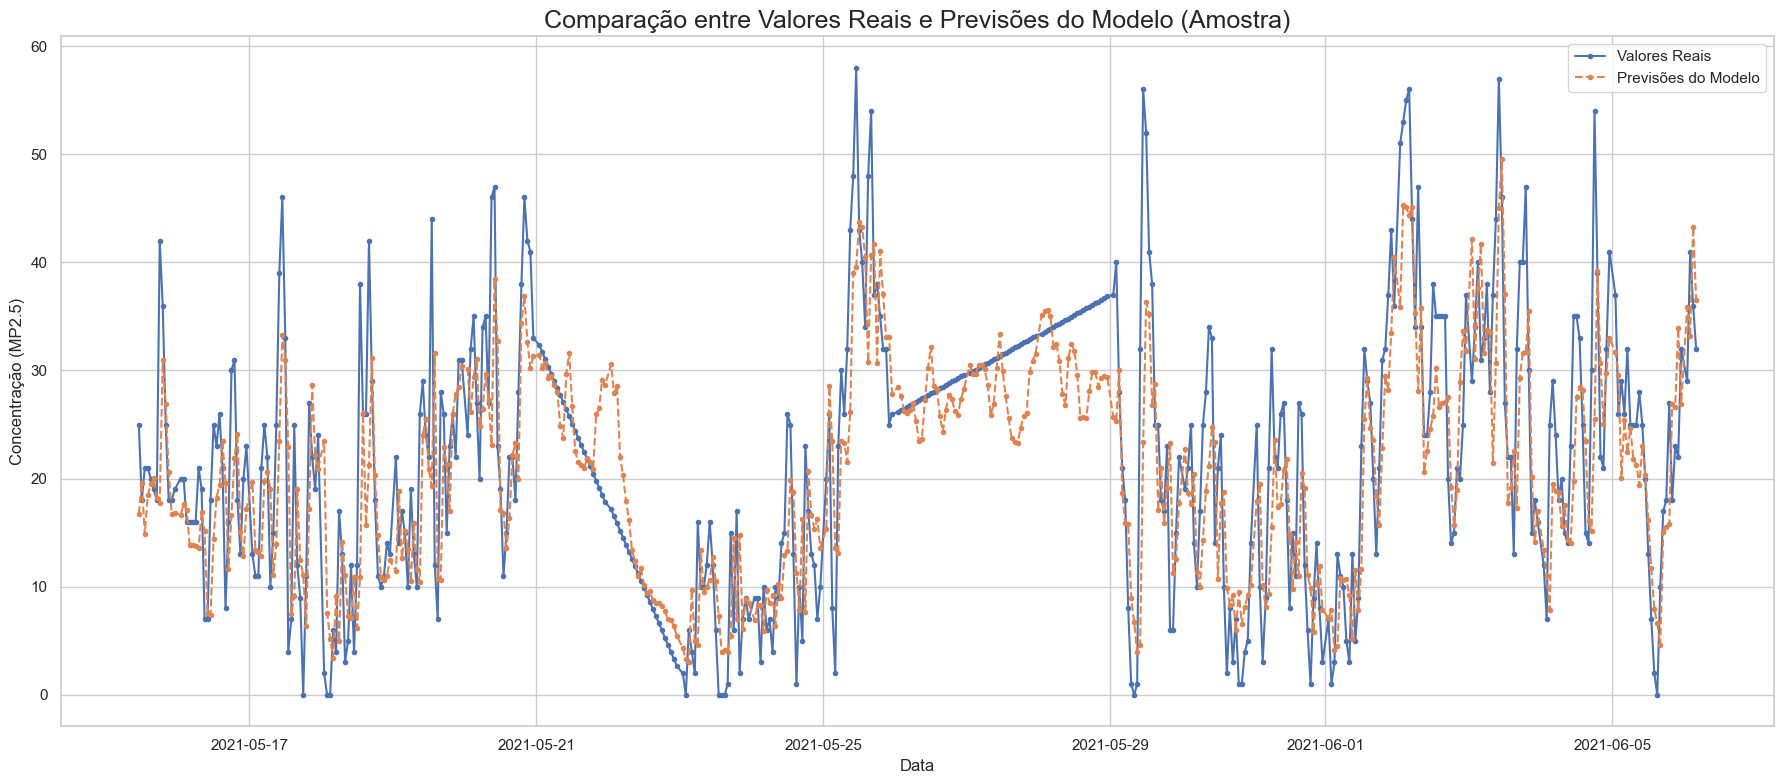

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

print("--- Treinando o Modelo XGBoost ---")

# Garante que os dados de treino existam
if 'X_treino' not in locals():
    print("ERRO: Dados de treino não encontrados. Execute as células anteriores primeiro.")
else:
    # Cria o modelo XGBoost Regressor
    # n_estimators: número de "árvores" que o modelo vai criar.
    # learning_rate: quão rápido o modelo aprende (valores menores são mais robustos).
    modelo = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        objective='reg:squarederror',
        n_jobs=-1 # Usa todos os processadores disponíveis para acelerar o treino
    )

    # Treina o modelo com os dados de treino
    print("Iniciando o treinamento... (Isso pode levar alguns minutos com muitos dados)")
    modelo.fit(X_treino, y_treino,
               eval_set=[(X_treino, y_treino), (X_teste, y_teste)],
               verbose=100) # Mostra o progresso do treino a cada 100 rodadas

    print("\n--- Treinamento Concluído! ---")

    # --- Avaliando o Modelo ---
    print("\n--- Avaliando o desempenho do modelo no conjunto de teste ---")
    
    # Faz as previsões no conjunto de teste
    previsoes = modelo.predict(X_teste)

    # Calcula as métricas de erro
    mae = mean_absolute_error(y_teste, previsoes)
    rmse = np.sqrt(mean_squared_error(y_teste, previsoes))

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print("\nInterpretação: O MAE nos diz que, em média, as previsões do modelo erram por +/- {mae:.2f} µg/m³.")

    # --- Visualizando as Previsões ---
    print("\n--- Gerando gráfico de Previsões vs. Valores Reais ---")
    
    # Cria um DataFrame para facilitar a plotagem
    df_resultados = pd.DataFrame({'Valores Reais': y_teste, 'Previsões': previsoes})

    plt.figure(figsize=(18, 8))
    # Plota apenas uma amostra dos dados para não poluir o gráfico (ex: 500 pontos)
    plt.plot(df_resultados.index[:500], df_resultados['Valores Reais'][:500], label='Valores Reais', marker='.', linestyle='-')
    plt.plot(df_resultados.index[:500], df_resultados['Previsões'][:500], label='Previsões do Modelo', marker='.', linestyle='--')

    plt.title('Comparação entre Valores Reais e Previsões do Modelo (Amostra)', fontsize=18)
    plt.xlabel('Data', fontsize=12)
    plt.ylabel(f'Concentração ({poluente_alvo})', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

In [ ]:
import joblib

# Define o caminho e o nome do arquivo para salvar o modelo
caminho_modelo = os.path.join('..', '05_modelos', 'modelo_xgboost_mp25.pkl')

# Define o caminho e o nome do arquivo para o dashboard
caminho_saida = os.path.join('..', '02_dados_processados', 'dados_para_dashboard.csv')

# Salva o objeto do modelo no arquivo
joblib.dump(modelo, caminho_modelo)

# Salva o df_wide em um novo arquivo CSV
df_wide.to_csv(caminho_saida)

print(f"Dados limpos exportados com sucesso para: {caminho_saida}")

print(f"Modelo salvo com sucesso em: {caminho_modelo}")

Modelo salvo com sucesso em: ..\05_modelos\modelo_xgboost_mp25.pkl
